In [1]:
import torch
import torch.nn as nn
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

In [2]:
path_data = '/home/mila/t/timothee.lesort/CL_Visualization/Archives/Datasets/encode_Core10Lifelong_resnet_1_train.pkl'
path_model_linear = '/home/mila/t/timothee.lesort/CL_Visualization/Archives/Core10Lifelong/Disjoint/1-tasks/pretrained_on_ImageNet/SingleH/seed-51/Linear_Masked/Logs/Disjoint/Head_baseline_Task_1.pth'
path_model_cosine = '/home/mila/t/timothee.lesort/CL_Visualization/Archives/Core10Lifelong/Disjoint/1-tasks/pretrained_on_ImageNet/SingleH/seed-51/CosLayer_Masked/Logs/Disjoint/Head_baseline_Task_1.pth'

In [3]:
import torchvision.models as models
resnet18 = models.resnet18()

In [4]:
with open(path_data, 'rb') as f:
    d = pkl.load(f)

In [5]:
from Models.Output_Layers.layer import CosineLayer

In [6]:
model_weights = torch.load(path_model_linear)
predictor_linear = nn.Linear(512, 10, bias=True)
predictor_linear.load_state_dict(model_weights)

model_weights = torch.load(path_model_cosine)
predictor_cosine = CosineLayer(512, 10)
predictor_cosine.load_state_dict(model_weights)

predictor = predictor_cosine

In [7]:
predictor(torch.tensor(d.data[0]).view(-1, 512))

tensor([[ 0.1056, -0.0278, -0.0388,  ..., -0.0321,  0.0455, -0.0270],
        [ 0.0326,  0.0067, -0.0623,  ..., -0.0710, -0.0071, -0.0068],
        [ 0.0938, -0.0301, -0.0470,  ...,  0.0003,  0.0510, -0.0232],
        ...,
        [ 0.0004, -0.0166,  0.0422,  ...,  0.0872, -0.0190,  0.0079],
        [ 0.0097,  0.0705, -0.0430,  ..., -0.0252, -0.0042,  0.0404],
        [ 0.0514,  0.0202,  0.0118,  ..., -0.0290, -0.0231,  0.0489]],
       grad_fn=<CatBackward>)

In [8]:
X = torch.tensor(d.data[0]).view(-1, 512)

In [9]:
U, S, V = torch.svd(X)

In [10]:
X_2d = torch.mm(X, V)

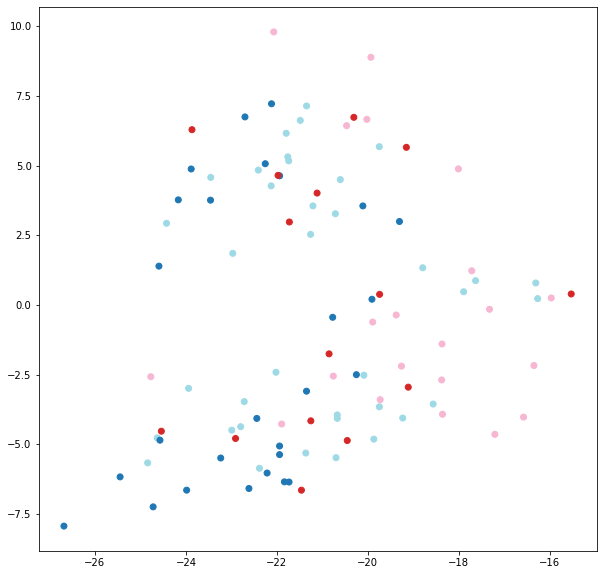

In [11]:
limit_n = 100
# indices = np.arange(X_2d.size(0))
indices = np.argwhere(d.data[1] < 4)
np.random.shuffle(indices)
indices = indices[:limit_n]

plt.figure(figsize=(10, 10))
plt.scatter(X_2d[indices, 0], X_2d[indices, 1], c=d.data[1][indices], cmap='tab20')

In [12]:
with torch.no_grad():
    dir_1 = predictor.weight[0] - predictor.weight[1]
    dir_1 /= torch.norm(dir_1)
    dir_2 = predictor.weight[3] - predictor.weight[2]
    dir_2 /= torch.norm(dir_2)

    X_2d_lin_x = torch.mv(X, dir_1)
    X_2d_lin_y = torch.mv(X, dir_2)
    
proj_mat = torch.stack((dir_1, dir_2))

In [13]:
lims = 6

xa, ya = np.mgrid[-lims:lims:1000j, -lims:lims:1000j]
x_display = np.vstack((xa.flatten(), ya.flatten())).T

with torch.no_grad():
    X_proj = torch.mm(torch.tensor(x_display, dtype=torch.float), proj_mat)
    preds_display = predictor(X_proj).argmax(dim=1)

(-6.0, 6.0)

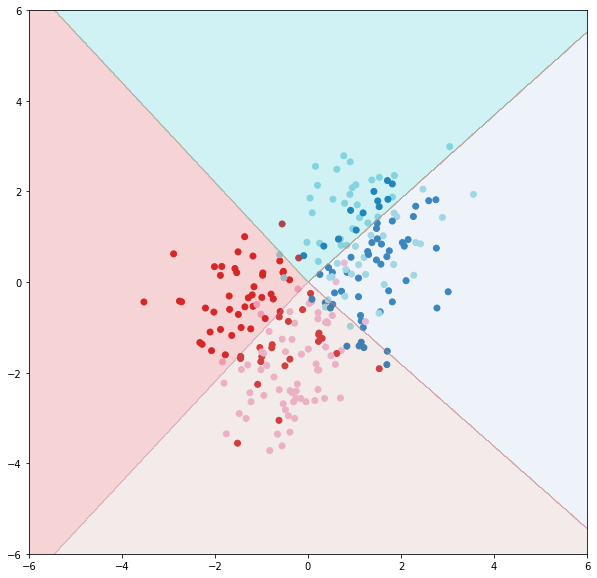

In [14]:
limit_n = 250
indices = np.argwhere(d.data[1] < 4)
np.random.shuffle(indices)
indices = indices[:limit_n]

plt.figure(figsize=(10, 10))
plt.scatter(X_2d_lin_x[indices], X_2d_lin_y[indices], c=d.data[1][indices], cmap='tab20')

cs = plt.contourf(xa, ya, preds_display.reshape(1000, 1000), cmap='tab20', alpha=.2)

plt.xlim(-lims, lims)
plt.ylim(-lims, lims)


In [15]:
loaded_model = pkl.load(open('Head_baseline_Task_1_kNN.pkl', 'rb'))
preds_display_kNN = loaded_model.predict(X_proj.numpy())

/home/mila/g/georgeth/pytenv3/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.24.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


(-6.0, 6.0)

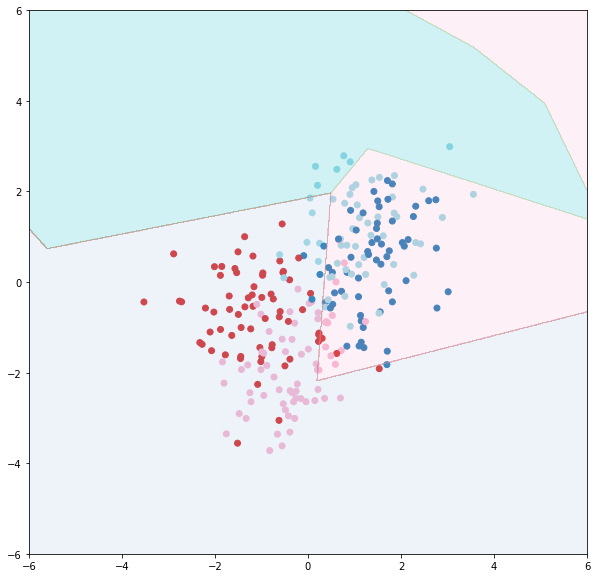

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(X_2d_lin_x[indices], X_2d_lin_y[indices], c=d.data[1][indices], cmap='tab20')

cs = plt.contourf(xa, ya, preds_display_kNN.reshape(1000, 1000), cmap='tab20', alpha=.2)

plt.xlim(-lims, lims)
plt.ylim(-lims, lims)

In [17]:
preds_display_kNN.shape

(1000000,)